# Example of upper limit computation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import pltdist, plotfitresult, plotlimit

import zfit
from zfit.loss import ExtendedUnbinnedNLL
from zfit.minimize import Minuit

from hepstats.hypotests.calculators import AsymptoticCalculator
from hepstats.hypotests import UpperLimit
from hepstats.hypotests.parameters import POI, POIarray

/Users/matthieumarinangeli/anaconda3/envs/tfn/lib/python3.7/site-packages/zfit-0.1.dev1243+g3358391.d20191114-py3.7.egg/zfit/util/execution.py:61: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


In [2]:
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['font.size'] = 16

### Fit of a Gaussian signal over an exponential background:

In [3]:
bounds = (0.1, 3.0)

# Data and signal

np.random.seed(0)
tau = -2.0
beta = -1/tau
data = np.random.exponential(beta, 300)
peak = np.random.normal(1.2, 0.1, 10)
data = np.concatenate((data,peak))
data = data[(data > bounds[0]) & (data < bounds[1])]

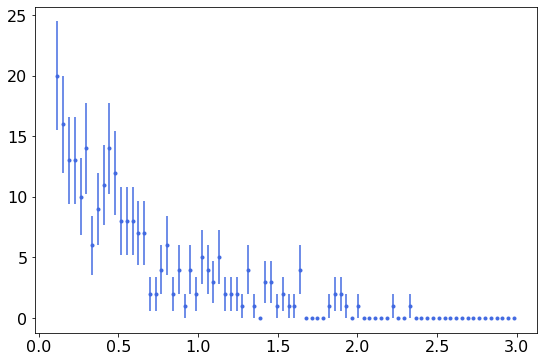

In [4]:
pltdist(data, bins=80, bounds=bounds)

In [5]:
obs = zfit.Space('x', limits=bounds)

In [6]:
lambda_ = zfit.Parameter("lambda",-2.0, -4.0, -1.0)
Nsig = zfit.Parameter("Nsig", 1., -20., len(data))
Nbkg = zfit.Parameter("Nbkg", len(data), 0., len(data)*1.1)

In [7]:
signal = Nsig * zfit.pdf.Gauss(obs=obs, mu=1.2, sigma=0.1)
background =  Nbkg * zfit.pdf.Exponential(obs=obs, lambda_=lambda_)
tot_model = signal + background

In [8]:
# Create the negative log likelihood
data_ = zfit.data.Data.from_numpy(obs=obs, array=data)
nll = ExtendedUnbinnedNLL(model=[tot_model], data=[data_]) 

In [9]:
# Instantiate a minuit minimizer
minimizer = Minuit()

In [10]:
# minimisation of the loss function
minimum = minimizer.minimize(loss=nll)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


FCN = -1077.4737271489062 
 TOTAL NCALL = 66 
 NCALLS = 66 
 
 
 EDM = 4.8784296721449974e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,Nbkg,251.591,16.6534,,,0,281.6,No
1,Nsig,4.51778,5.75076,,,-20,256,No
2,lambda,-1.93036,0.139642,,,-4,-1,No


Text(0, 0.5, 'number of events')

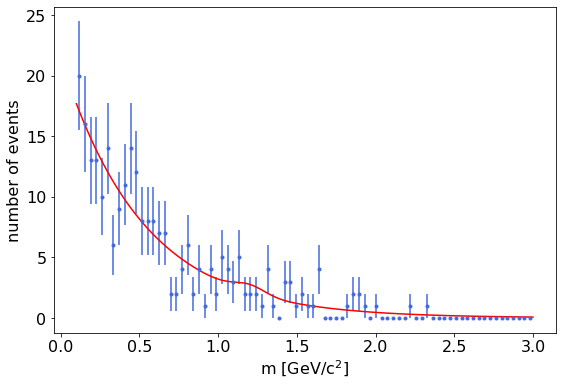

In [11]:
nbins = 80
pltdist(data, nbins, bounds)
plotfitresult(tot_model, bounds, nbins, data)
plt.xlabel("m [GeV/c$^2$]")
plt.ylabel("number of events")

### Upper limit:

Since the signal yield Nsig = $4.5 \pm 5.8$  is consistent with zero signal we compute the CLs upper limit at 95% confidence level on Nsig.

In [12]:
# instantation of the calculator
calculator = AsymptoticCalculator(nll, minimizer)
calculator.bestfit = minimum #optionnal

In [13]:
# parameter of interest of the null hypothesis
poinull = POIarray(Nsig, np.linspace(0.0, 25, 20))
# parameter of interest of the alternative hypothesis
poialt = POI(Nsig, 0)

In [14]:
# instantation of the discovery test
ul = UpperLimit(calculator, poinull, poialt)

In [15]:
ul.upperlimit(alpha=0.05, CLs=True);


Get fit best values for nuisance parameters for the alternative hypothesis!


FCN = -1077.1288611117425 
 TOTAL NCALL = 47 
 NCALLS = 47 
 
 
 EDM = 5.910169473261007e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,Nbkg,255.996,15.8919,,,0,281.6,No
1,lambda,-1.88702,0.126041,,,-4,-1,No



Observed upper limit: Nsig = 15.725784747406346
Expected upper limit: Nsig = 11.927442041887158
Expected upper limit +1 sigma: Nsig = 16.596396280677116
Expected upper limit -1 sigma: Nsig = 8.592750403611896
Expected upper limit +2 sigma: Nsig = 22.24864429383046
Expected upper limit -2 sigma: Nsig = 6.400549971360598


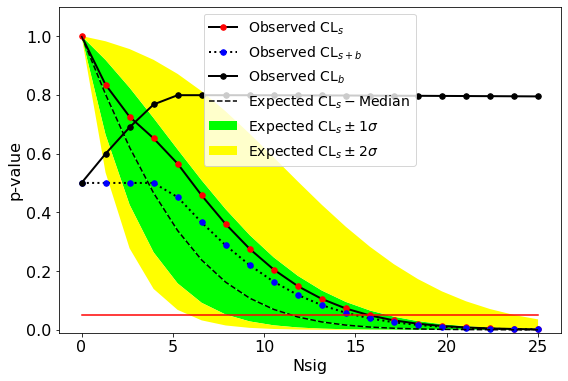

In [16]:
ax = plotlimit(poinull.values, ul.pvalues(CLs=True), alpha=0.05, CLs=True)
ax.set_xlabel("Nsig");